# TINT Demonstration


This notebook will take you through the following process:

1. GET DATA - Obtain nexrad data from Amazon S3
2. GRID - Map data to cartesian grids using Py-ART
3. TRACK - Perform cell tracking using TINT
4. VISUALIZE - Visualize the tracks

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image, display
import tempfile
import os
import shutil
from mpl_toolkits.basemap import Basemap
import pandas as pd
import os

from mpl_toolkits.basemap import Basemap
import glob
import matplotlib
import cartopy.crs as ccrs


import pyart
#from tint.data_utils import get_nexrad_keys
from tint import Cell_tracks, animate
from tint.visualization import embed_mp4_as_gif


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## 1. GET DATA


In [4]:
import tempfile

from boto.s3.connection import S3Connection
from datetime import datetime, timedelta

import pyart
def get_nexrad_keys(site, start=None, end=None):
    """
    Get generator of pyart radar objects for all nexrad data between two
    datetimes from Amazon S3.
    ----------
    site : string
        site code e.g. 'khgx'
    start : string
        datetime e.g. '20180101_000000'
    end : string
        same format as start

    """
    fmt = '%Y%m%d_%H%M%S'

    if start is None:
        start = datetime.utcnow() - timedelta(hours=1)
    else:
        start = datetime.strptime(start, fmt)
    if end is None:
        end = datetime.utcnow()
    else:
        end = datetime.strptime(end, fmt)
    if end < start:
        print('end datetime precedes start datetime')
        return

    site = site.upper()

    dates = []
    day_i = start
    while day_i < end:
        dates.append(day_i)
        day_i += timedelta(days=1)

    date_keys = [datetime.strftime(date, '%Y/%m/%d/' + site) for date in dates]

    conn = S3Connection(anon=True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    keys = [key for date_key in date_keys
            for key in list(bucket.list(date_key))
            if '.tar' not in str(key)]

    if len(keys) == 0:
        print('Found 0 files.')
        return

    # Key ealier for keys before 'V06'
    if '.gz>' in str(keys[0]):
        key_fmt = site + '%Y%m%d_%H%M%S_V06.gz>'
        key_fmt_earlier = site + '%Y%m%d_%H%M%S.gz>'
        key_fmt_3 = site + '%Y%m%d_%H%M%S_V03.gz>'
    else:
        key_fmt = site + '%Y%m%d_%H%M%S_V06>'
        key_fmt_earlier = site + '%Y%m%d_%H%M%S>'
        key_fmt_3 = site + '%Y%m%d_%H%M%S_V03>'

    key_dts = []
    for key in keys:
        if 'MDM' in str(key):
            pass
        else:
            try:
                key_dts.append(datetime.strptime(str(key).split('/')[-1], key_fmt))
            except ValueError:
                try:
                    key_dts.append(
                        datetime.strptime(str(key).split('/')[-1], key_fmt_earlier))
                except:
                    key_dts.append(
                        datetime.strptime(str(key).split('/')[-1], key_fmt_3))
    key_dts = zip(keys, key_dts)
    keys = [key for key, dt in key_dts if dt > start and dt < end]
    print('Found', len(keys), 'keys.')
    return keys
# Let's get some nexrad data from Amazon S3 to use for tracking
# I know of some storm cells that passed over Houston back in July of 2015
keys = get_nexrad_keys('kenx', start='19980312_020000', end='19980312_060000')

Found 34 keys.


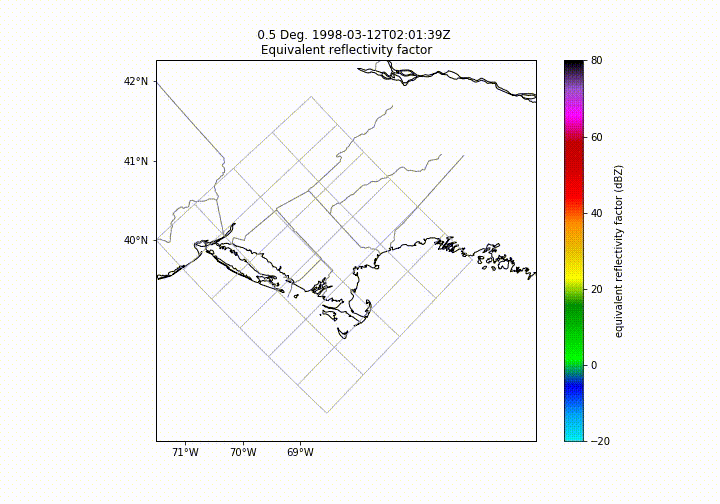

In [5]:
# We can visualize this data using pyart and matplotlib
fig = plt.figure(figsize=(10, 7))

def read_nexrad_key(key):
    """
    Returns pyart radar object from nexrad S3 key.
    """
    tmp = tempfile.NamedTemporaryFile()
    key.get_contents_to_filename(tmp.name)
    return pyart.io.read_nexrad_archive(tmp.name)
# Use for cases without V06 at the end
# def plot_ppi(key):
#     """ Plots ppi map of nexrad data given S3 key. """
#     plt.clf()
#     radar = read_nexrad_key(key)
#     refl = np.squeeze(radar.get_field(sweep=0, field_name='reflectivity'))
#     display = pyart.graph.RadarMapDisplay(radar)
#     loc = pyart.io.nexrad_common.get_nexrad_location('KCXX')
#     lon0 = loc[1]
#     lat0 = loc[0]
#     m = Basemap(projection='lcc', lon_0=-73, lat_0=42.5,
#                      llcrnrlat=40, llcrnrlon=-78,
#                      urcrnrlat=45, urcrnrlon=-68, resolution='l')
#     # set up the plotting grid for the data
#     x, y = display._get_x_y(0, True, None)
#     x0,y0 = m(lon0,lat0)
#     glons,glats = m((x0+x*1000.), (y0+y*1000.),inverse=True)
#     refl[refl<15] = np.nan
#     refl[refl>35] = np.nan
#     axes = fig.add_subplot(111, projection=ccrs.PlateCarree())
#     axes.set_extent([-78, -68, 40, 45], ccrs.PlateCarree())
#     axes.gridlines(color="black", linestyle="dotted")
#     cmap = 'pyart_NWSRef'
#     levs = np.linspace(0, 80, 41, endpoint=True)
#     norm = matplotlib.colors.BoundaryNorm(levs, 256)
#     # create a colormesh of the reflectivity using with the plot settings defined above
#     p1 = axes.pcolormesh(glons, glats, refl, norm=norm, cmap=cmap, transform=ccrs.PlateCarree())
#     del display, radar

# Use for cases with V06 at the end
def plot_ppi(key):
    """ Plots ppi map of nexrad data given S3 key. """
    plt.clf()
    radar = read_nexrad_key(key)
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi_map('reflectivity', resolution='10m',
                         sweep=0,vmin=-20, vmax=80, cmap='pyart_NWSRef', fig=fig,
                         lat_lines=np.arange(40, 45, 1),
                         lon_lines=np.arange(-75, -68, 1),
                         min_lon=-75, max_lon=-68, min_lat=40,
                         max_lat=45,
                         lon_0=radar.longitude['data'][0],
                         lat_0=radar.latitude['data'][0])
    plt.savefig('/mnt/c/Users/CoeFamily/Desktop' + str(key) + '.png')
    del display, radar


ppi_anim = FuncAnimation(fig, plot_ppi, frames=keys, interval=1000)
tmp_anim = tempfile.NamedTemporaryFile()
ppi_anim.save(tmp_anim.name + '.mp4', writer='ffmpeg')
embed_mp4_as_gif(tmp_anim.name + '.mp4')
os.remove(tmp_anim.name + '.mp4')
plt.close()

## 2. GRID

### Disclaimer
If you are running this notebook and don't want this data to remain on your filesystem, make sure you run the last cell in the notebook. If your kernel crashes for some reason, you can manually remove the the path printed after the following cell.

In [6]:
# Looks like there are some interesting cells coming off the gulf.
# Let's make a function that maps these volumes to cartesian grids using pyart.
# Most of the cells seem to be in the bottom right quadrant, so we'll only grid
# that part of the domain to save time.

def get_grid(radar):
    """ Returns grid object from radar object. """
    loc = pyart.io.nexrad_common.get_nexrad_location('KBOX')
    lon0 = loc[1] ; lat0 = loc[0]
    radar.longitude['data'][0] = lon0
    radar.latitude['data'][0] = lat0
    radar.range['data'] = radar.range['data']+2500
    radar.init_gate_altitude()
    radar.init_gate_longitude_latitude()
    gatefilter = pyart.filters.GateFilter(radar)
    #gatefilter.exclude_below('reflectivity',10)

    grid = pyart.map.grid_from_radars(
        radar, grid_shape=(31, 241, 241),
        grid_limits=((0, 2000), (200000.,200000.), (-200000., 200000.)),
        fields=['reflectivity'],gatefilters=gatefilter, gridding_algo='map_gates_to_grid',
        h_factor=0., nb=0.6, bsp=1., min_radius=200.)
    return grid


# Let's write these grids to a temporary location so that we can reuse them.
# This might take a few minutes
tmp_dir = '/mnt/c/Users/CoeFamily/Desktop'
print('temporary directory:', tmp_dir)
filenames = []
for num, key in enumerate(keys):
    print('saving grid', num)
    radar = read_nexrad_key(key)
    grid = get_grid(radar)
    name = os.path.join(tmp_dir, 'grid_' + str(num).zfill(3) + '.nc')
    filenames.append(name)
    pyart.io.write_grid(name, grid)
    del radar, grid

temporary directory: /mnt/c/Users/CoeFamily/Desktop
saving grid 0
saving grid 1
saving grid 2
saving grid 3
saving grid 4
saving grid 5
saving grid 6
saving grid 7
saving grid 8
saving grid 9
saving grid 10
saving grid 11
saving grid 12
saving grid 13
saving grid 14
saving grid 15
saving grid 16
saving grid 17
saving grid 18
saving grid 19
saving grid 20
saving grid 21
saving grid 22
saving grid 23
saving grid 24
saving grid 25
saving grid 26
saving grid 27
saving grid 28
saving grid 29
saving grid 30
saving grid 31
saving grid 32
saving grid 33


In [5]:
# Now we can easily instantiate generators of these grids like so
grids = (pyart.io.read_grid(fn) for fn in filenames)

## 3. TRACK

In [6]:
# First, let's instantiate a tracks object and view the default parameters
tracks_obj = Cell_tracks()
tracks_obj.params

{'FIELD_THRESH': 28,
 'MIN_SIZE': 8,
 'SEARCH_MARGIN': 4000,
 'FLOW_MARGIN': 10000,
 'MAX_FLOW_MAG': 50,
 'MAX_DISPARITY': 999,
 'MAX_SHIFT_DISP': 15,
 'ISO_THRESH': 8,
 'ISO_SMOOTH': 3,
 'GS_ALT': 1500}

In [7]:
# The cells we're interested in look a bit small. Let's reduce the minimum size threshold.
tracks_obj.params['MIN_SIZE'] = 4
# We can change this parameter to find cells above a certain dBz threshold
tracks_obj.params['FIELD_THRESH'] = 10
# We'll give the generator of grids we made earlier to the get_tracks method of our tracks object.
tracks_obj.get_tracks(grids)

No cells found in scan 0
No cells found in scan 1
No cells found in scan 2
No cells found in scan 3
No cells found in scan 4
No cells found in scan 5
No cells found in scan 6
No cells found in scan 7
No cells found in scan 8
No cells found in scan 9
No cells found in scan 10
No cells found in scan 11
No cells found in scan 12
No cells found in scan 13
No cells found in scan 14
No cells found in scan 15
No cells found in scan 16
No cells found in scan 17
No cells found in scan 18
No cells found in scan 19
No cells found in scan 20
No cells found in scan 21
No cells found in scan 22
No cells found in scan 23
No cells found in scan 24
No cells found in scan 25
No cells found in scan 26
No cells found in scan 27
No cells found in scan 28
No cells found in scan 29
No cells found in scan 30
No cells found in scan 31
No cells found in scan 32
No cells found in scan 33
No cells found in scan 34
No cells found in scan 35
No cells found in scan 36
No cells found in scan 37
No cells found in scan

In [8]:
# Now we can view the 'tracks' attribute of our tracks object to see the results.
tracks_obj.tracks.head(20)

""


In [9]:
tracks_obj.tracks.groupby(level='uid').get_group('0')[['lat','lon']]
pointA = (tracks_obj.tracks.groupby(level='uid').get_group('0')['lat'][0],tracks_obj.tracks.groupby(level='uid').get_group('0')['lon'][0])
#pointA
tracks_obj.tracks.groupby(level='uid').get_group('0')['lat'].values

ValueError: level name uid is not the name of the index

## 4. VISUALIZE

In [ ]:
# We can visualize these tracks to assess the performance of the algorithm.
# First we need to make another generator of the same grids for the animator
grids = (pyart.io.read_grid(fn) for fn in filenames)

In [ ]:
# Let's save the animation in our temp directory so that it will be cleaned up later.
animate(tracks_obj, grids, os.path.join(tmp_dir, 'tint_demo_anim20'),
        lat_lines=np.arange(40, 45, .5),
        lon_lines=np.arange(-78, -68, .5),
        tracers=True)

In [ ]:
# The animator saved an mp4 to our local directory. Now we can embed it as a gif in this notebook.
embed_mp4_as_gif(os.path.join(tmp_dir, 'tint_demo_anim20.mp4'))

In [ ]:
# Let's find the cells that were tracked for the most frames
tracks_obj.tracks.groupby(level='uid').size().sort_values(ascending=False)[:]

In [ ]:
# Now we can view these cells from a lagrangian perspective
grids = (pyart.io.read_grid(fn) for fn in filenames)  # refresh grid generator
animate(tracks_obj, grids, os.path.join(tmp_dir, 'tint_demo_lagrangian'), style='lagrangian', uid='0', alt=2000)

In [ ]:
embed_mp4_as_gif(os.path.join(tmp_dir, 'tint_demo_lagrangian.mp4'))

In [ ]:
import math

def calculate_initial_compass_bearing(pointA, pointB):
    """
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    """
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [ ]:
# We can view the attributes of this cell throughout its lifetime
# For each cell, compute the average direction of motion

coordinates = []
for group in tracks_obj.tracks.groupby(level='uid').groups:
    temp = tracks_obj.tracks.groupby(level='uid').get_group(group) 
    lats = temp['lat']
    lons = temp['lon']
    if (len(lats) <=2 or len(lons) <=2):
        pass
    elif(len(lats) != len(lons) ):
        pass
    else:
        temp_coords = []
        for i in range(len(lats)-1):
            pointA = (lats[i],lons[i])
            pointB = (lats[i+1],lons[i+1])
            temp_direction = calculate_initial_compass_bearing(pointA, pointB)
            if temp_direction % 90 == 0:
                pass
            else:
                temp_coords.append(temp_direction)
        print(temp_coords)
        print(np.mean(temp_coords) - np.std(temp_coords))
        coordinates.append((group,np.mean(temp_coords),np.mean(temp_coords)+180))
        
coordinates

In [ ]:
df = pd.DataFrame(coordinates,columns=['Cell','Direction To','Direction From'])
df.to_csv('/mnt/c/Users/CoeFamily/Documents/12222008.csv',index=False)

## Clean Up

In [ ]:
# Now we can delete the directory containing all the data and output from this demo.
shutil.rmtree(tmp_dir)
print('temporary directory removed')

In [ ]:
df.mean()